## Importing important libraries

In [31]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, RobertaConfig
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import re
from nltk.tokenize import sent_tokenize

## Hyperparameters 

Easy and straightforward hyperparameter tuning

In [32]:
# Hyperparameters and paths
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
EPOCHS = 30
TEST_SIZE = 0.1
RANDOM_STATE = 42
MAX_LEN = 128  # Maximum sequence length for tokenization
NUM_LABELS = 6  # Update based on your dataset

base_save_path = "Roberta_v3_4f_checkpoints"
checkpoint_path = "Roberta_v3_4f_checkpoints/cp-{epoch:04d}.ckpt"

# Load and preprocess the dataset
file_path = 'emotion_data_merged_4.csv'  # Update this path
data = pd.read_csv(file_path)

## F1 Metric and tokenizer function

In [33]:
def f1_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Setup and Data Preparation

Loading the dataset, preprocessing the text, and preparing the data for the model.

In [34]:
data = data.dropna(subset=['emotion']).query("emotion != 'neutral'")
data = data.drop_duplicates()

In [35]:
# Expanded contraction mapping
contractions_dict = {
    "i'm": "i am", "im": "i am", "i m": "i am",
    "you're": "you are", "youre": "you are",
    "he's": "he is", "hes": "he is",
    "she's": "she is", "shes": "she is",
    "it's": "it is", "its": "it is",
    "we're": "we are", "were": "we are",
    "they're": "they are", "theyre": "they are",
    "that's": "that is", "thats": "that is", "that s": "that is",
    "that'd": "that would", "thatd": "that would",
    "who's": "who is", "whos": "who is",
    "what's": "what is", "whats": "what is",
    "where's": "where is", "wheres": "where is",
    "when's": "when is", "whens": "when is",
    "why's": "why is", "whys": "why is",
    "how's": "how is", "hows": "how is",
    "ain't": "am not", "aint": "am not",
    "aren't": "are not", "arent": "are not",
    "isn't": "is not", "isnt": "is not",
    "wasn't": "was not", "wasnt": "was not",
    "weren't": "were not", "werent": "were not",
    "haven't": "have not", "havent": "have not",
    "hasn't": "has not", "hasnt": "has not",
    "hadn't": "had not", "hadnt": "had not",
    "won't": "will not", "wont": "will not",
    "wouldn't": "would not", "wouldnt": "would not",
    "don't": "do not", "dont": "do not",
    "doesn't": "does not", "doesnt": "does not",
    "didn't": "did not", "didnt": "did not",
    "can't": "cannot", "cant": "cannot",
    "couldn't": "could not", "couldnt": "could not",
    "shouldn't": "should not", "shouldnt": "should not",
    "mightn't": "might not", "mightnt": "might not",
    "mustn't": "must not", "mustnt": "must not",
}

# Create a regex pattern for contractions, enabling case-insensitive matching
contraction_patterns = r'\b(' + '|'.join([re.escape(k) for k in contractions_dict.keys()]) + r')\b'
contractions_re = re.compile(contraction_patterns, re.IGNORECASE)

In [36]:
def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        # Fetch the correct replacement string from the dictionary using lowercase match
        return contractions_dict[match.group().lower()]
    # Use the sub method to replace all matches
    expanded_text = contractions_re.sub(replace, text)
    return expanded_text

def clean_text(text):
    text = text.strip()  # Strip leading/trailing whitespace
    text = expand_contractions(text)  # Expand contractions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#\w+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)  # Remove emoticons and unicode characters
    
    # Split text into sentences, strip each sentence, then join back with a space
    sentences = sent_tokenize(text)
    cleaned_sentences = [sentence.strip() for sentence in sentences]
    text = ' '.join(cleaned_sentences)
    
    return text

In [37]:
data['sentence'] = data['sentence'].apply(clean_text)

# Drop duplicates
data = data.drop_duplicates()

# Overview of the dataset
print("Preview of the dataset:")
print(data.head())

print("\nSummary statistics of the dataset:")
print(data.describe())

print("\nInformation about columns in the dataset:")
print(data.info())

# Feature extraction
data['ends_with_exclamation'] = data['sentence'].str.endswith('!').astype(int)
data['ends_with_question'] = data['sentence'].str.endswith('?').astype(int)
data['ends_with_period'] = data['sentence'].str.endswith('.').astype(int)

Preview of the dataset:
                                            sentence    emotion
0  i am feeling rather rotten so i am not very am...    sadness
1        i am updating my blog because i feel shitty    sadness
2  i never make her separate from me because i do...    sadness
3  i left with my bouquet of red and yellow tulip...  happiness
4    i was feeling a little vain when i did this one    sadness

Summary statistics of the dataset:
                              sentence    emotion
count                           476723     476723
unique                          476696          6
top     Okay. My word! Those are snug.  happiness
freq                                 2     189600

Information about columns in the dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 476723 entries, 0 to 662398
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  476723 non-null  object
 1   emotion   476723 non-null  object
dt

In [38]:
data.head()

,sentence,emotion,ends_with_exclamation,ends_with_question,ends_with_period
0,i am feeling rather rotten so i am not very am...,sadness,0,0,0
1,i am updating my blog because i feel shitty,sadness,0,0,0
2,i never make her separate from me because i do...,sadness,0,0,0
3,i left with my bouquet of red and yellow tulip...,happiness,0,0,0
4,i was feeling a little vain when i did this one,sadness,0,0,0


In [8]:
# Encode the labels
label_encoder = LabelEncoder()
data['emotion_encoded'] = label_encoder.fit_transform(data['emotion'])

# Initial train-validation split
train_data, initial_val_data = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data['emotion_encoded'])

# Generate embeddings for the validation sentences
model = SentenceTransformer('all-MiniLM-L6-v2')
val_embeddings = model.encode(initial_val_data['sentence'].values)

# Clustering
kmeans = MiniBatchKMeans(n_clusters=int(len(initial_val_data) * TEST_SIZE / 10), random_state=RANDOM_STATE)
val_cluster_labels = kmeans.fit_predict(val_embeddings)
initial_val_data['cluster_label'] = val_cluster_labels

# Sample from clusters to form the final validation set
# Instead of sampling a fixed number from each cluster, we aim to maintain the overall desired validation set size
desired_val_size = int(len(data) * TEST_SIZE)  # This is the target size for the validation set

# Calculate the sampling ratio for each cluster to contribute to the final validation set
cluster_counts = initial_val_data['cluster_label'].value_counts()
sampling_ratios = cluster_counts / cluster_counts.sum()

# Calculate the number of samples to take from each cluster
samples_per_cluster = (sampling_ratios * desired_val_size).round().astype(int)

# Sample from each cluster
val_data_list = []
for cluster_label, n_samples in samples_per_cluster.items():
    cluster_data = initial_val_data[initial_val_data['cluster_label'] == cluster_label]
    sampled_data = cluster_data.sample(n=min(n_samples, len(cluster_data)), random_state=RANDOM_STATE)
    val_data_list.append(sampled_data)

# Concatenate all sampled data to form the final validation set
val_data = pd.concat(val_data_list).reset_index(drop=True)

# Ensure final validation set size is close to desired validation set size
print(f"Final validation set size: {len(val_data)} sentences")
print(f"Desired validation set size: {desired_val_size} sentences")

INFO: Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO: Use pytorch device_name: cuda


Batches:   0%|          | 0/1490 [00:00<?, ?it/s]

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


Final validation set size: 47673 sentences
Desired validation set size: 47672 sentences


In [9]:
# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Function to encode text data using the tokenizer
def encode_sentences(dataframe):
    input_ids = []
    attention_masks = []

    for sentence in dataframe['sentence']:
        encoded_dict = tokenizer.encode_plus(
            sentence,                      # Sentence to encode.
            add_special_tokens=True,       # Add '[CLS]' and '[SEP]'.
            max_length=MAX_LEN,            # Pad & truncate all sentences.
            padding='max_length',
            return_attention_mask=True,    # Construct attention masks.
            return_tensors='tf',           # Return TensorFlow tensors.
            truncation=True                # Ensure truncation is explicitly enabled.
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert lists to tensors. Ensure the output is a single tensor for each.
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    
    return input_ids, attention_masks

In [10]:
# Tokenize the text for both training and validation sets
train_input_ids, train_attention_masks = encode_sentences(train_data)
val_input_ids, val_attention_masks = encode_sentences(val_data)

# Prepare numerical features
numerical_features_train = train_data[['ends_with_exclamation', 'ends_with_question', 'ends_with_period']]
numerical_features_val = val_data[['ends_with_exclamation', 'ends_with_question', 'ends_with_period']]

# Standardize the numerical features
scaler = StandardScaler()
numerical_features_train = scaler.fit_transform(numerical_features_train)
numerical_features_val = scaler.transform(numerical_features_val)

# Prepare labels
train_labels = train_data['emotion_encoded'].values
val_labels = val_data['emotion_encoded'].values

2024-03-27 21:29:20.624011: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-27 21:29:20.624318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22620 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6


## Model training

Setting up the RoBERTa model, defining the training loop, and initiating the training process.

In [11]:
# RoBERTa text input model
def build_model(base_model, num_numerical_features, num_labels):
    # Inputs
    text_input = Input(shape=(MAX_LEN,), dtype='int32', name='text_input')
    mask_input = Input(shape=(MAX_LEN,), dtype='int32', name='mask_input')
    numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')

    # RoBERTa model
    roberta_output = base_model([text_input, mask_input])[0][:, 0, :]  # Use the pooled output

    # Concatenate RoBERTa output with numerical features
    concatenated = Concatenate()([roberta_output, numerical_input])

    # Further dense layers can be added here
    x = Dense(64, activation='relu')(concatenated)
    x = Dropout(0.2)(x)
    output = Dense(num_labels, activation='softmax')(x)

    model = Model(inputs=[text_input, mask_input, numerical_input], outputs=output)
    
    return model

In [12]:
# Load the pre-trained RoBERTa model
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=NUM_LABELS)

# Build the custom model
model = build_model(roberta_model.roberta, 3, NUM_LABELS)  # 3 numerical features

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy', f1_metric]  # Add other metrics as needed

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # Log when training is stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='min'
)

In [14]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    factor=0.1,             # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=3,             # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,              # Log when learning rate is reduced
    mode='min',             # Mode 'min' because we want to minimize validation loss
    min_lr=0.00001          # Lower bound on the learning rate
)

In [15]:
# Fit label encoder and return encoded labels
labels_encoded = data['emotion_encoded']

In [16]:
# Count the number of occurrences of each class
class_counts = np.unique(labels_encoded, return_counts=True)[1]

# Calculate total number of samples
total_samples = len(labels_encoded)

# Calculate class weights inversely proportional to the class frequencies
class_weights = {i: total_samples/(count * len(class_counts)) for i, count in enumerate(class_counts)}

In [17]:
# Specify the directory where you want to save the checkpoints
checkpoint_dir = os.path.dirname(checkpoint_path)

# Ensure the directory exists. If it doesn't, create it.
os.makedirs(base_save_path, exist_ok=True)

# Specify the checkpoint file path pattern
checkpoint_path = os.path.join(base_save_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a ModelCheckpoint callback
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True, 
    save_best_only=True,  # Saves only the best model
    monitor='val_loss',  # Monitoring validation loss to determine the best model
    mode='min',  # Since we're monitoring 'val_loss', 'min' mode saves the model when the metric has decreased
    save_freq='epoch')  # Saving the model after each epoch

In [18]:
# Assuming 'val_data' is your final validation dataset
# And assuming the total number of sentences in your original dataset is 490,000

total_sentences = len(data)
num_val_sentences = len(val_data)

percentage_for_validation = (num_val_sentences / total_sentences) * 100

print(f"The validation set constitutes {percentage_for_validation:.2f}% of the entire dataset.")


The validation set constitutes 10.00% of the entire dataset.


In [21]:
# Prepare TensorFlow datasets (adjust to include numerical features)
train_dataset = tf.data.Dataset.from_tensor_slices(({"text_input": train_input_ids, "mask_input": train_attention_masks, "numerical_input": numerical_features_train}, train_labels)).shuffle(len(train_input_ids)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(({"text_input": val_input_ids, "mask_input": val_attention_masks, "numerical_input": numerical_features_val}, val_labels)).batch(BATCH_SIZE)

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler, cp_callback],
    # Adjust the class_weight parameter as needed based on your previous calculations
)


Epoch 1/30


2024-03-27 21:37:14.585322: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3be8784b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-27 21:37:14.585365: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-27 21:37:14.593982: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-27 21:37:14.626342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1711575434.736189 3744009 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3352/3352 [==============================] - ETA: 0s - loss: 0.1633 - accuracy: 0.9457 - f1_metric: 1.0631
Epoch 1: val_loss improved from inf to 0.08056, saving model to Roberta_v3_4f_checkpoints/cp-0001.ckpt
3352/3352 [==============================] - 9167s 3s/step - loss: 0.1633 - accuracy: 0.9457 - f1_metric: 1.0631 - val_loss: 0.0806 - val_accuracy: 0.9712 - val_f1_metric: 0.9761 - lr: 1.0000e-05
Epoch 2/30
3352/3352 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9720 - f1_metric: 0.9860
Epoch 2: val_loss improved from 0.08056 to 0.07976, saving model to Roberta_v3_4f_checkpoints/cp-0002.ckpt
3352/3352 [==============================] - 8088s 2s/step - loss: 0.0818 - accuracy: 0.9720 - f1_metric: 0.9860 - val_loss: 0.0798 - val_accuracy: 0.9722 - val_f1_metric: 0.9727 - lr: 1.0000e-05
Epoch 3/30
3352/3352 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9758 - f1_metric: 0.9789
Epoch 3: val_loss improved from 0.07976 to 0.07556, sav

In [22]:
results = model.evaluate(val_dataset)
print(f"Validation loss: {results[0]}, Validation accuracy: {results[1]}, Validation F1 Score: {results[2]}")

373/373 [==============================] - 100s 269ms/step - loss: 0.0738 - accuracy: 0.9736 - f1_metric: 0.9729
Validation loss: 0.07382901757955551, Validation accuracy: 0.9735909104347229, Validation F1 Score: 0.9729248285293579


## Visualization

Generate usefull insights on the training

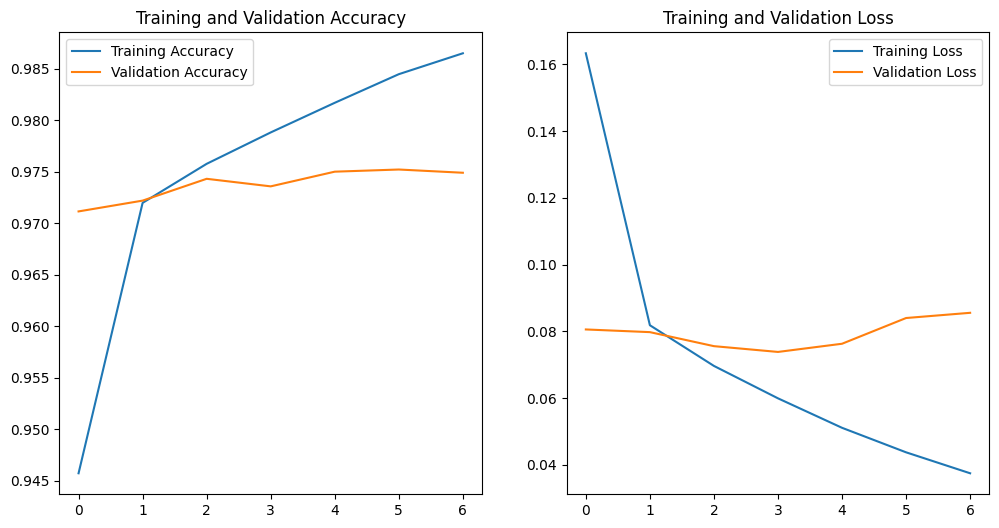

In [23]:
# Plotting training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


##  Generate the Confusion Matrix and Metrics

With the true labels and predictions, we can now generate a confusion matrix and calculate other evaluation metrics like precision, recall, and F1-score.

1490/1490 [==============================] - 124s 82ms/step


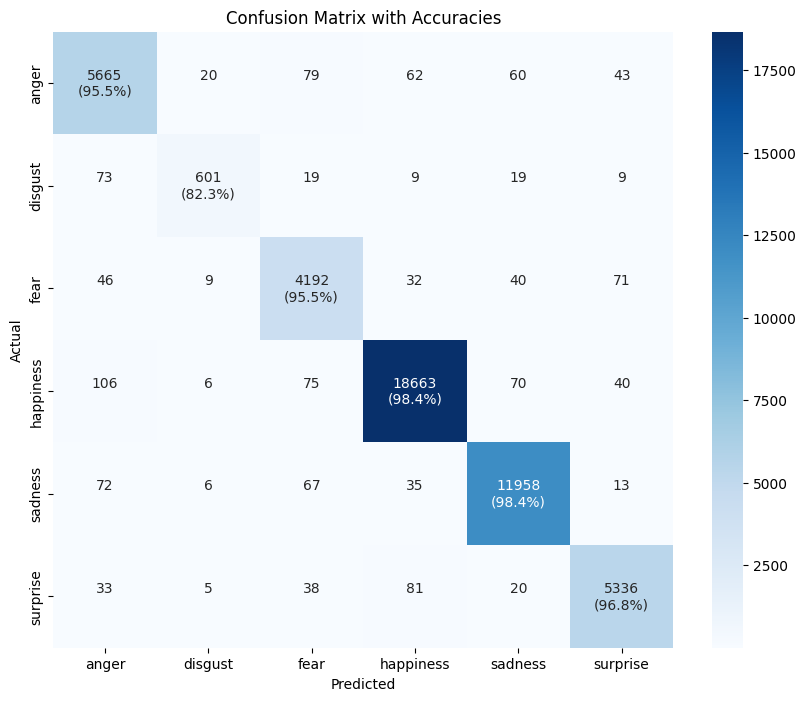

In [25]:
# Predict classes with the model
# Adjust the predict call to match your model inputs
predictions = model.predict({
    "text_input": val_input_ids, 
    "mask_input": val_attention_masks, 
    "numerical_input": numerical_features_val
})

# Assuming your model's final layer uses a softmax activation, predictions are probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, predicted_labels)

# Calculate per-class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)

# Create an annotated confusion matrix with accuracies
cm_with_acc = cm.astype('str')  # Convert counts to string for annotation
for i in range(len(cm)):
    for j in range(len(cm[i])):
        # Append accuracy to the diagonal elements
        if i == j:
            cm_with_acc[i][j] = f"{cm[i][j]}\n({accuracies[i]*100:.1f}%)"
        else:
            cm_with_acc[i][j] += "\n "

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=cm_with_acc, fmt='', ax=ax, cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with Accuracies')
plt.show()

## Prepare the Submission DataFrame and Save

In [27]:
# Function to encode sentences (tokenize)
def encode_sentences(df):
    encoded_dict = tokenizer.batch_encode_plus(
        df['sentence'].values,
        add_special_tokens=True,
        max_length=128,  # Adjust to your setup
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='np'
    )
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [28]:
# Load the test dataset
test_df = pd.read_csv('test (1).csv', sep='\t')

# Ensure 'sentence' column is string and apply the clean_text function
test_df['sentence'] = test_df['sentence'].astype(str).apply(clean_text)

# Add punctuation features to the test dataset
test_df['ends_with_exclamation'] = test_df['sentence'].str.endswith('!').astype(int)
test_df['ends_with_question'] = test_df['sentence'].str.endswith('?').astype(int)
test_df['ends_with_period'] = test_df['sentence'].str.endswith('.').astype(int)

# Prepare the numerical features for the test dataset
numerical_features_test = test_df[['ends_with_exclamation', 'ends_with_question', 'ends_with_period']].values
# Assuming 'scaler' is already fitted with your training data
numerical_features_test = scaler.transform(numerical_features_test)

# Tokenize the sentences in the test dataset
test_input_ids, test_attention_masks = encode_sentences(test_df)

# Prepare the TensorFlow dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices(({
    "text_input": test_input_ids, 
    "mask_input": test_attention_masks, 
    "numerical_input": numerical_features_test
})).batch(BATCH_SIZE)

# Predictions
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Assuming label_encoder is fitted with your original labels
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Prepare your submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Make sure 'id' column exists in your test_df
    'emotion': predicted_emotions
})

# Save the submission file
submission_df.to_csv('Roberta_V3_4f_task12_submission.csv', index=False, sep=',')

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


12/12 [==============================] - 6s 245ms/step


In [30]:
import joblib

# Define the base directory for saving
base_save_dir = "Roberta_V3_4f_task12_model"

# Ensure the base directory exists
if not os.path.exists(base_save_dir):
    os.makedirs(base_save_dir)

# Specify the paths for the model, tokenizer, and label encoder
model_save_path = os.path.join(base_save_dir, "model")
tokenizer_save_path = os.path.join(base_save_dir, "tokenizer")
label_encoder_save_path = os.path.join(base_save_dir, "label_encoder.joblib")

# Save the TF model
model.save(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the label encoder
joblib.dump(label_encoder, label_encoder_save_path)

INFO: Assets written to: Roberta_V3_4f_task12_model/model/assets


['Roberta_V3_4f_task12_model/label_encoder.joblib']

In [ ]:
data_sub = 'Roberta_V3_4f_task12.csv'

# Load the dataset
data_submission = pd.read_csv(data_sub)

# Define the mapping from integer labels to emotion names
emotion_mapping = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise'
}

# Apply the mapping to the 'emotion' column
data_submission['emotion'] = data_submission['emotion'].map(emotion_mapping)
# Save the submission file
data_submission.to_csv('Roberta_V3_4f_task12.csv', index=False, sep=',')